https://github.com/siddhu2984/HandGesturedControlledDrones/blob/main/hand_detection.py

In [ ]:
!pip install livelossplot

In [ ]:
!pip install mediapipe

In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import PIL
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import mediapipe as mp
from PIL import Image

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import mediapipe as mp


In [3]:
def extract_landmarks(frame):
    imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
    results = hands.process(imgRGB)
    landmarks = []
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            for lm in handLms.landmark:
                landmarks.append((lm.x, lm.y))
    return landmarks

In [4]:
print(os.listdir())

['.git', '.gitignore', '21BRS1121 Hand Recognition review 2.docx', '21BRS1121 Research Paper.docx', '21BRS1121 Research Paper.pdf', 'Dataset_Binary', 'Dataset_RGB', 'Data_Collection.ipynb', 'full_model.h5', 'hand recognition sequence diagram.png', 'hand-gesture-recognition 1.ipynb', 'hand-gesture-recognition.ipynb', 'hand_gesture_recognition.py', 'main.ipynb', 'models', 'model_json.json', 'model_weights.weights.h5', 'predict.py', 'predicted.py', 'predicted1.py', 'templates', 'videos']


In [2]:
# Path to the directory containing videos
videos_dir = 'videos'

# Initialize an empty DataFrame to store landmarks
df = pd.DataFrame(columns=[f"{i}_{j}" for i in range(0, 21) for j in ['x', 'y']] + ['class'])
df1 = pd.DataFrame(columns=['x_0_1', 'y_0_1', 'x_1_2', 'y_1_2', 'x_2_3', 'y_2_3', 'x_3_4', 'y_3_4', 'x_0_5', 'y_0_5', 'x_5_6', 'y_5_6', 'x_6_7', 'y_6_7', 'x_7_8', 'y_7_8', 'x_5_9', 'y_5_9', 'x_9_10', 'y_9_10', 'x_10_11', 'y_10_11', 'x_11_12', 'y_11_12', 'x_9_13', 'y_9_13', 'x_13_14', 'y_13_14', 'x_14_15', 'y_14_15', 'x_15_16', 'y_15_16', 'x_13_17', 'y_13_17', 'x_17_18', 'y_17_18', 'x_18_19', 'y_18_19', 'x_19_20', 'y_19_20', 'x_0_17', 'y_0_17', 'class'])


In [6]:
mpHands = mp.solutions.hands
mpDraw = mp.solutions.drawing_utils

# Initialize MediaPipe Hands
hands = mpHands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
for class_folder in os.listdir(videos_dir):
    class_path = os.path.join(videos_dir, class_folder)
    if os.path.isdir(class_path):
        for video_file in os.listdir(class_path):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(class_path, video_file)
                # Open the video file
                cap = cv2.VideoCapture(video_path)
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = hands.process(imgRGB)
                    if results.multi_hand_landmarks:
                        for hand_landmarks in results.multi_hand_landmarks:
                            row_data = {}
                            k = len(df)
                            for i, landmark in enumerate(hand_landmarks.landmark):
                                df.loc[k, f"{i}_x"] = landmark.x
                                df.loc[k, f"{i}_y"] = landmark.y
                            df.loc[k, "class"] = class_folder
                    # Extract landmarks from the frame
                    # landmarks = extract_landmarks(frame)
                    # if landmarks:
                    #     # Append landmarks to the DataFrame
                    #     df.loc[len(df)] = np.array(landmarks).flatten()
                    #     classes.append(class_folder)
                cap.release()


In [7]:
df.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,class
0,0.355898,0.719739,0.430502,0.666517,0.488573,0.598238,0.472361,0.526675,0.406035,0.49977,...,0.59719,0.256204,0.527194,0.23898,0.482738,0.264055,0.543346,0.287247,0.587804,Forward
1,0.355431,0.722138,0.431963,0.669824,0.489102,0.59904,0.469728,0.528283,0.401208,0.495551,...,0.599097,0.254362,0.526782,0.235207,0.483948,0.26297,0.545631,0.289606,0.59178,Forward
2,0.357297,0.721418,0.43237,0.671487,0.489717,0.597921,0.469423,0.529262,0.403774,0.494809,...,0.600457,0.25458,0.524624,0.234607,0.484112,0.261728,0.546055,0.288658,0.591976,Forward
3,0.357206,0.722031,0.433073,0.671744,0.490415,0.597258,0.469594,0.529449,0.404009,0.495055,...,0.601127,0.254518,0.524364,0.234387,0.483357,0.261304,0.546039,0.288141,0.591947,Forward
4,0.356765,0.721666,0.432531,0.672346,0.490067,0.597701,0.469951,0.52952,0.404452,0.494792,...,0.601054,0.254498,0.523288,0.234416,0.483451,0.261078,0.546142,0.287909,0.592123,Forward


In [16]:
# df.columns
qwe = {}
cntr = 0
for i in df.columns:
    qwe[i] = cntr
    cntr += 1
newdffirst = ['0_x', '0_y', '1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '0_x', '0_y', '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '5_x', '5_y', '9_x', '9_y', '10_x', '10_y', '11_x', '11_y', '9_x', '9_y', '13_x', '13_y', '14_x', '14_y', '15_x', '15_y', '13_x', '13_y', '17_x', '17_y', '18_x', '18_y', '19_x', '19_y', '0_x', '0_y']
newdfsecond = ['1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '4_x', '4_y', '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '8_x', '8_y', '9_x', '9_y', '10_x', '10_y', '11_x', '11_y', '12_x', '12_y', '13_x', '13_y', '14_x', '14_y', '15_x', '15_y', '16_x', '16_y', '17_x', '17_y', '18_x', '18_y', '19_x', '19_y', '20_x', '20_y', '17_x', '17_y']
for i in newdffirst:
    print(qwe[i], end=", ")
print()
for i in newdfsecond:
    print(qwe[i], end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 10, 11, 12, 13, 14, 15, 10, 11, 18, 19, 20, 21, 22, 23, 18, 19, 26, 27, 28, 29, 30, 31, 26, 27, 34, 35, 36, 37, 38, 39, 0, 1, 
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 34, 35, 

In [19]:
newdf = ['x_0_1', 'y_0_1', 'x_1_2', 'y_1_2', 'x_2_3', 'y_2_3', 'x_3_4', 'y_3_4', 'x_0_5', 'y_0_5', 'x_5_6', 'y_5_6', 'x_6_7', 'y_6_7', 'x_7_8', 'y_7_8', 'x_5_9', 'y_5_9', 'x_9_10', 'y_9_10', 'x_10_11', 'y_10_11', 'x_11_12', 'y_11_12', 'x_9_13', 'y_9_13', 'x_13_14', 'y_13_14', 'x_14_15', 'y_14_15', 'x_15_16', 'y_15_16', 'x_13_17', 'y_13_17', 'x_17_18', 'y_17_18', 'x_18_19', 'y_18_19', 'x_19_20', 'y_19_20', 'x_0_17', 'y_0_17']
newdffirst = ['0_x', '0_y', '1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '0_x', '0_y', '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '5_x', '5_y', '9_x', '9_y', '10_x', '10_y', '11_x', '11_y', '9_x', '9_y', '13_x', '13_y', '14_x', '14_y', '15_x', '15_y', '13_x', '13_y', '17_x', '17_y', '18_x', '18_y', '19_x', '19_y', '0_x', '0_y']
newdfsecond = ['1_x', '1_y', '2_x', '2_y', '3_x', '3_y', '4_x', '4_y', '5_x', '5_y', '6_x', '6_y', '7_x', '7_y', '8_x', '8_y', '9_x', '9_y', '10_x', '10_y', '11_x', '11_y', '12_x', '12_y', '13_x', '13_y', '14_x', '14_y', '15_x', '15_y', '16_x', '16_y', '17_x', '17_y', '18_x', '18_y', '19_x', '19_y', '20_x', '20_y', '17_x', '17_y']
newdffirstl = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 10, 11, 12, 13, 14, 15, 10, 11, 18, 19, 20, 21, 22, 23, 18, 19, 26, 27, 28, 29, 30, 31, 26, 27, 34, 35, 36, 37, 38, 39, 0, 1]
newdfsecondl = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 34, 35]
k = 0
for i, j in zip(newdffirstl, newdfsecondl):
    df1[newdf[k]] = test[i]-test[j]
    k += 1
df1.head()

,x_0_1,y_0_1,x_1_2,y_1_2,x_2_3,y_2_3,x_3_4,y_3_4,x_0_5,y_0_5,...,y_13_17,x_17_18,y_17_18,x_18_19,y_18_19,x_19_20,y_19_20,x_0_17,y_0_17,class
0,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward
1,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward
2,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward
3,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward
4,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward


In [8]:
# df1['x_0_1'] = df['0_x'] - df['1_x']
# df1['y_0_1'] = df['0_y'] - df['1_y']
# df1['x_1_2'] = df['1_x'] - df['2_x']
# df1['y_1_2'] = df['1_y'] - df['2_y']
# df1['x_2_3'] = df['2_x'] - df['3_x']
# df1['y_2_3'] = df['2_y'] - df['3_y']
# df1['x_3_4'] = df['3_x'] - df['4_x']
# df1['y_3_4'] = df['3_y'] - df['4_y']
# df1['x_0_5'] = df['0_x'] - df['5_x']
# df1['y_0_5'] = df['0_y'] - df['5_y']
# df1['x_5_6'] = df['5_x'] - df['6_x']
# df1['y_5_6'] = df['5_y'] - df['6_y']
# df1['x_6_7'] = df['6_x'] - df['7_x']
# df1['y_6_7'] = df['6_y'] - df['7_y']
# df1['x_7_8'] = df['7_x'] - df['8_x']
# df1['y_7_8'] = df['7_y'] - df['8_y']
# df1['x_5_9'] = df['5_x'] - df['9_x']
# df1['y_5_9'] = df['5_y'] - df['9_y']
# df1['x_9_10'] = df['9_x'] - df['10_x']
# df1['y_9_10'] = df['9_y'] - df['10_y']
# df1['x_10_11'] = df['10_x'] - df['11_x']
# df1['y_10_11'] = df['10_y'] - df['11_y']
# df1['x_11_12'] = df['11_x'] - df['12_x']
# df1['y_11_12'] = df['11_y'] - df['12_y']
# df1['x_9_13'] = df['9_x'] - df['13_x']
# df1['y_9_13'] = df['9_y'] - df['13_y']
# df1['x_13_14'] = df['13_x'] - df['14_x']
# df1['y_13_14'] = df['13_y'] - df['14_y']
# df1['x_14_15'] = df['14_x'] - df['15_x']
# df1['y_14_15'] = df['14_y'] - df['15_y']
# df1['x_15_16'] = df['15_x'] - df['16_x']
# df1['y_15_16'] = df['15_y'] - df['16_y']
# df1['x_13_17'] = df['13_x'] - df['17_x']
# df1['y_13_17'] = df['13_y'] - df['17_y']
# df1['x_17_18'] = df['17_x'] - df['18_x']
# df1['y_17_18'] = df['17_y'] - df['18_y']
# df1['x_18_19'] = df['18_x'] - df['19_x']
# df1['y_18_19'] = df['18_y'] - df['19_y']
# df1['x_19_20'] = df['19_x'] - df['20_x']
# df1['y_19_20'] = df['19_y'] - df['20_y']
# df1['x_0_17'] = df['0_x'] - df['17_x']
# df1['y_0_17'] = df['0_y'] - df['17_y']
# df1['class'] = df['class']
# df1.head()

,x_0_1,y_0_1,x_1_2,y_1_2,x_2_3,y_2_3,x_3_4,y_3_4,x_0_5,y_0_5,...,y_13_17,x_17_18,y_17_18,x_18_19,y_18_19,x_19_20,y_19_20,x_0_17,y_0_17,class
0,-0.074604,0.053222,-0.058071,0.068279,0.016212,0.071563,0.066326,0.026905,-0.086467,0.265422,...,-0.038093,0.017224,0.044457,-0.025075,-0.060608,-0.023192,-0.044458,0.099694,0.192545,Forward
1,-0.076532,0.052314,-0.057139,0.070784,0.019375,0.070756,0.06852,0.032732,-0.082926,0.266135,...,-0.035232,0.019156,0.042834,-0.027763,-0.061683,-0.026637,-0.046149,0.101069,0.195356,Forward
2,-0.075074,0.049932,-0.057347,0.073566,0.020294,0.068658,0.065649,0.034454,-0.080649,0.267745,...,-0.034546,0.019973,0.040512,-0.027121,-0.061944,-0.02693,-0.045921,0.102716,0.196795,Forward
3,-0.075867,0.050286,-0.057341,0.074486,0.02082,0.067809,0.065585,0.034394,-0.080917,0.268829,...,-0.034663,0.020131,0.041006,-0.026917,-0.062681,-0.026837,-0.045909,0.102689,0.197667,Forward
4,-0.075766,0.04932,-0.057536,0.074645,0.020117,0.068181,0.065498,0.034727,-0.081197,0.26814,...,-0.034049,0.020081,0.039837,-0.026662,-0.062691,-0.02683,-0.045981,0.102267,0.198378,Forward


In [17]:
# Path to save the CSV file
csv_file_path = 'landmarks3.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)


In [ ]:
x, y = df.drop('class', axis=1), df['class']
# Train a Random Forest classifier
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_classifier.score(X_test, y_test)
print(f'Model accuracy: {accuracy}')


Model accuracy: 1.0


In [9]:
# Path to save the CSV file
csv_file_path = 'landmarks2.csv'

# Save the DataFrame to a CSV file
df1.to_csv(csv_file_path, index=False)


In [10]:
x, y = df1.drop('class', axis=1), df1['class']
# Train a Random Forest classifier
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_classifier.score(X_test, y_test)
print(f'Model accuracy: {accuracy}')


Model accuracy: 1.0


In [11]:
# Path to save the trained model
model_file_path = 'rfctrained_model4.joblib'

# Save the trained model
joblib.dump(rf_classifier, model_file_path)

print('Trained model saved successfully.')


Trained model saved successfully.


In [25]:
x, y = df.drop('class', axis=1), df['class']
# Train a Random Forest classifier
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=1000)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_classifier.score(X_test, y_test)
print(f'Model accuracy: {accuracy}')
# Path to save the trained model
model_file_path = 'rfctrained_model2.joblib'

# Save the trained model
joblib.dump(rf_classifier, model_file_path)

print('Trained model saved successfully.')


Model accuracy: 1.0
Trained model saved successfully.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Dataset_RGB/Dataset_RGB/

down  eight  five  four  left  nine  one  right  seven	six  stop  three  two  up  zero


### take a look at the images

In [17]:
base = 'Dataset_RGB/Dataset_RGB' # LocalHost
# base = '/content/drive/MyDrive/Dataset_RGB/Dataset_RGB/' # Google Colab

In [ ]:
sample = os.path.join(base,'five/img 4.jpg')
sample

'/content/drive/MyDrive/Dataset_RGB/Dataset_RGB/five/img 4.jpg'

In [ ]:
classes = os.listdir(base)
mpHands = mp.solutions.hands
mpDraw = mp.solutions.drawing_utils

# Initialize MediaPipe Hands
hands = mpHands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Create an empty DataFrame to store the landmarks
df = pd.DataFrame(columns=[f"{i}_{j}" for i in range(0, 21) for j in ['x', 'y']] + ['class'])

# Process each image
for cls in classes:
    image_paths = os.path.join(base, cls)
    for image_path in os.listdir(image_paths)[:10]:
        # Read the image
        img = cv2.imread(os.path.join(image_paths,image_path))
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image to detect hand landmarks
        results = hands.process(imgRGB)

        # Extract hand landmarks and append to the DataFrame
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                row_data = {}
                k = len(df)
                for i, landmark in enumerate(hand_landmarks.landmark):
                    df.loc[k, f"{i}_x"] = landmark.x
                    df.loc[k, f"{i}_y"] = landmark.y
                df.loc[k, "class"] = cls

# Display the DataFrame
df.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,class
0,0.572883,0.893595,0.384975,0.834223,0.241417,0.71059,0.163566,0.586682,0.093284,0.506812,...,0.178578,0.692284,0.533389,0.775889,0.427451,0.832689,0.355617,0.882932,0.291098,right
1,0.545386,0.882684,0.363911,0.821204,0.226586,0.699349,0.154109,0.580868,0.09348,0.497341,...,0.170138,0.67752,0.528313,0.766662,0.426233,0.826055,0.355864,0.874928,0.287642,right
2,0.602548,0.948542,0.416321,0.87975,0.277674,0.737938,0.21558,0.611872,0.155366,0.528977,...,0.215162,0.73128,0.584138,0.823261,0.482881,0.885467,0.415962,0.940598,0.350048,right
3,0.54079,0.93621,0.364591,0.851733,0.238828,0.722826,0.183725,0.598327,0.13561,0.512778,...,0.218206,0.637908,0.555964,0.621071,0.436197,0.60482,0.369206,0.589997,0.312083,right
4,0.597495,0.933617,0.410009,0.865142,0.272199,0.736077,0.204428,0.613347,0.14275,0.518187,...,0.210226,0.719938,0.573441,0.780045,0.46527,0.821222,0.39202,0.853442,0.320441,right


0 0.5765518546104431 0.9178593158721924
1 0.3860313296318054 0.8490488529205322
2 0.24895553290843964 0.7139421701431274
3 0.18226057291030884 0.5896283984184265
4 0.11616012454032898 0.5117824673652649
5 0.3632121682167053 0.5277443528175354
6 0.3498804569244385 0.3749198615550995
7 0.3654645085334778 0.2918124794960022
8 0.382474809885025 0.2201768159866333
9 0.47733497619628906 0.5040785074234009
10 0.46779385209083557 0.3346039652824402
11 0.4718363583087921 0.23836542665958405
12 0.4733313322067261 0.1583746075630188
13 0.5808852314949036 0.5141853094100952
14 0.573139488697052 0.3599169850349426
15 0.5668818950653076 0.2736259698867798
16 0.5614873766899109 0.20334592461585999
17 0.6886411309242249 0.552926242351532
18 0.6812409162521362 0.4303213655948639
19 0.6734257340431213 0.35584700107574463
20 0.6682513952255249 0.2877248525619507


(-0.5, 299.5, 299.5, -0.5)

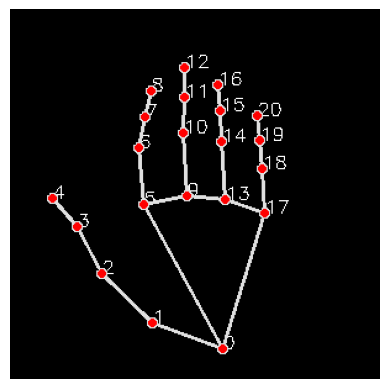

In [22]:
sample = os.path.join(base,'five/img 61.jpg')
img = cv2.imread(sample)
# cv2.imshow('1',img)
black = np.zeros(img.shape, dtype="uint8")
# cv2.imshow('2',black)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imshow('3',imgRGB)
# plt.axis('off')
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=False,
                      max_num_hands=2,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5)
mpDraw = mp.solutions.drawing_utils

results = hands.process(imgRGB)
if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            # print(handLms)
            for id, lm in enumerate(handLms.landmark):
                print(id,lm.x,lm.y, sep=' ')
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                cv2.circle(black, (cx, cy), 3, (255, 0, 255), cv2.FILLED)
                cv2.putText(black, str(id), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            mpDraw.draw_landmarks(black, handLms, mpHands.HAND_CONNECTIONS)

plt.imshow(black[:,:,::-1])
plt.axis('off')

### split the dataset

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
output_dir = os.path.join('/content/drive/MyDrive/Dataset_RGB', 'working')
output_dir

'/content/drive/MyDrive/Dataset_RGB/working'

In [ ]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

In [ ]:
make_dir(output_dir)
make_dir(train_dir)
make_dir(val_dir)
make_dir(test_dir)

In [ ]:
for i in os.listdir(base):
    for j in [train_dir, val_dir, test_dir]:
        make_dir(os.path.join(j,i))

In [ ]:
for i in os.listdir(base):
    total_imgs = os.listdir(os.path.join(base, i))
    Xtrain, Xvaltest = train_test_split(total_imgs, test_size=0.3)
    Xval, Xtest = train_test_split(Xvaltest, test_size=0.5)

    for tr in Xtrain:
        sample = os.path.join(base, i, tr)
        img = cv2.imread(sample)
        black = np.zeros(img.shape, dtype="uint8")
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)
        if results.multi_hand_landmarks:
                for handLms in results.multi_hand_landmarks:
                    for id, lm in enumerate(handLms.landmark):
                        # print(id,lm)
                        h, w, c = img.shape
                        cx, cy = int(lm.x * w), int(lm.y * h)
                        cv2.circle(black, (cx, cy), 3, (255, 0, 255), cv2.FILLED)
                    mpDraw.draw_landmarks(black, handLms, mpHands.HAND_CONNECTIONS)

        skeleton_img = Image.fromarray(black)
        skeleton_img.save(os.path.join(train_dir, i, tr))

    for v in Xval:
        sample = os.path.join(base, i, v)
        img = cv2.imread(sample)
        black = np.zeros(img.shape, dtype="uint8")
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)
        if results.multi_hand_landmarks:
                for handLms in results.multi_hand_landmarks:
                    for id, lm in enumerate(handLms.landmark):
                        # print(id,lm)
                        h, w, c = img.shape
                        cx, cy = int(lm.x * w), int(lm.y * h)
                        cv2.circle(black, (cx, cy), 3, (255, 0, 255), cv2.FILLED)
                    mpDraw.draw_landmarks(black, handLms, mpHands.HAND_CONNECTIONS)

        skeleton_img = Image.fromarray(black)
        skeleton_img.save(os.path.join(val_dir, i, v))

    for te in Xtest:
        sample = os.path.join(base, i, te)
        img = cv2.imread(sample)
        black = np.zeros(img.shape, dtype="uint8")
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)
        if results.multi_hand_landmarks:
                for handLms in results.multi_hand_landmarks:
                    for id, lm in enumerate(handLms.landmark):
                        # print(id,lm)
                        h, w, c = img.shape
                        cx, cy = int(lm.x * w), int(lm.y * h)
                        cv2.circle(black, (cx, cy), 3, (255, 0, 255), cv2.FILLED)
                    mpDraw.draw_landmarks(black, handLms, mpHands.HAND_CONNECTIONS)

        skeleton_img = Image.fromarray(black)
        skeleton_img.save(os.path.join(test_dir, i, te))

In [ ]:
for i in os.listdir(base):
    print(f'there are {len(os.listdir(os.path.join(train_dir, i)))} images in the train dataset for class [{i}]')
    print(f'there are {len(os.listdir(os.path.join(val_dir, i)))} images in the val dataset for class [{i}]')
    print(f'there are {len(os.listdir(os.path.join(test_dir, i)))} images in the test dataset for class [{i}]\n')

there are 700 images in the train dataset for class [right]
there are 150 images in the val dataset for class [right]
there are 150 images in the test dataset for class [right]

there are 700 images in the train dataset for class [six]
there are 150 images in the val dataset for class [six]
there are 150 images in the test dataset for class [six]

there are 700 images in the train dataset for class [seven]
there are 150 images in the val dataset for class [seven]
there are 150 images in the test dataset for class [seven]

there are 704 images in the train dataset for class [up]
there are 151 images in the val dataset for class [up]
there are 152 images in the test dataset for class [up]

there are 707 images in the train dataset for class [zero]
there are 151 images in the val dataset for class [zero]
there are 152 images in the test dataset for class [zero]

there are 707 images in the train dataset for class [two]
there are 151 images in the val dataset for class [two]
there are 152 

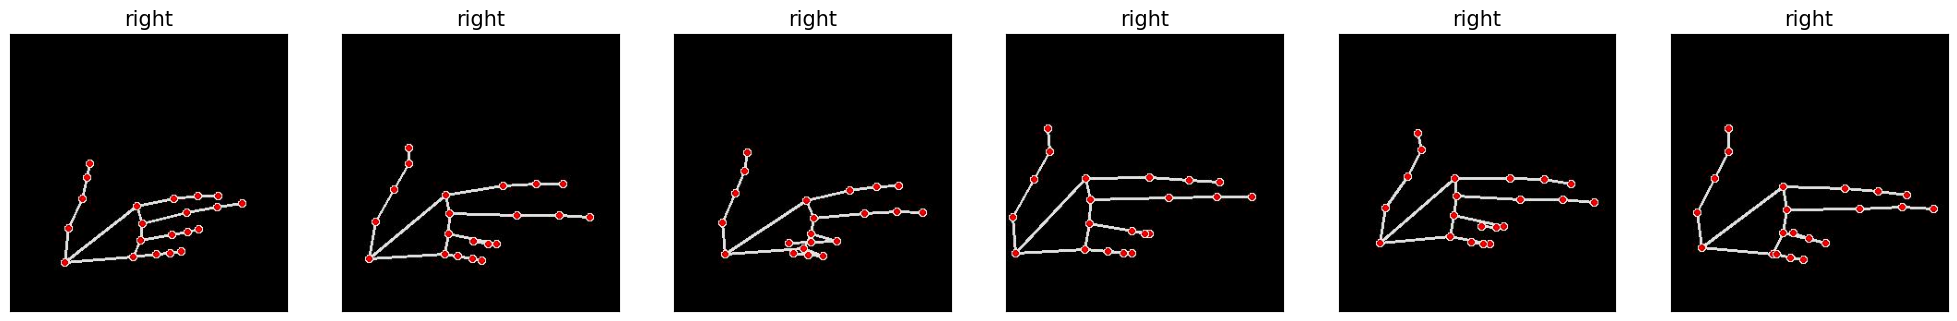

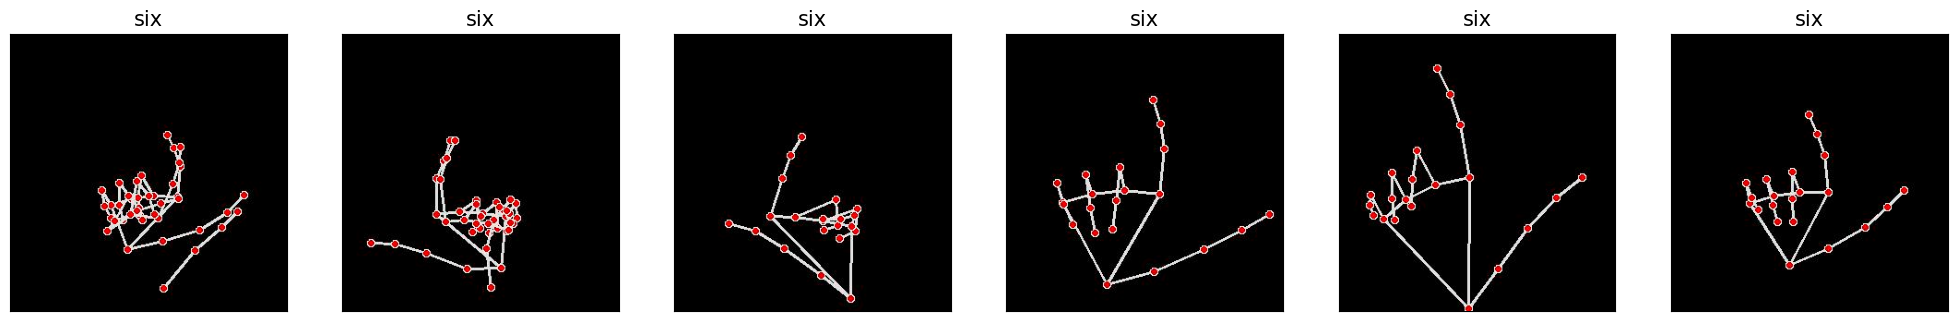

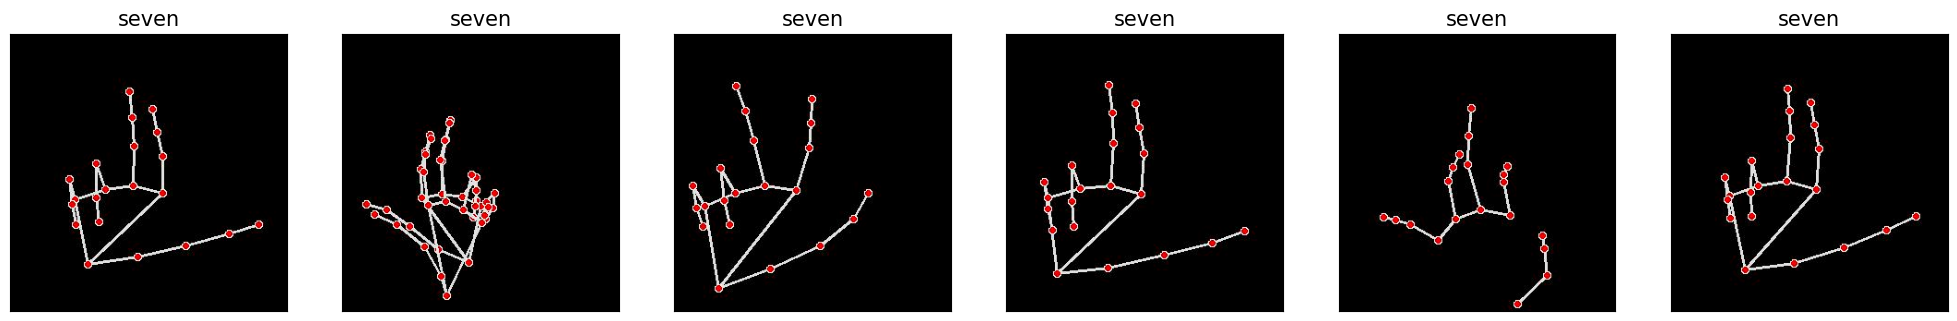

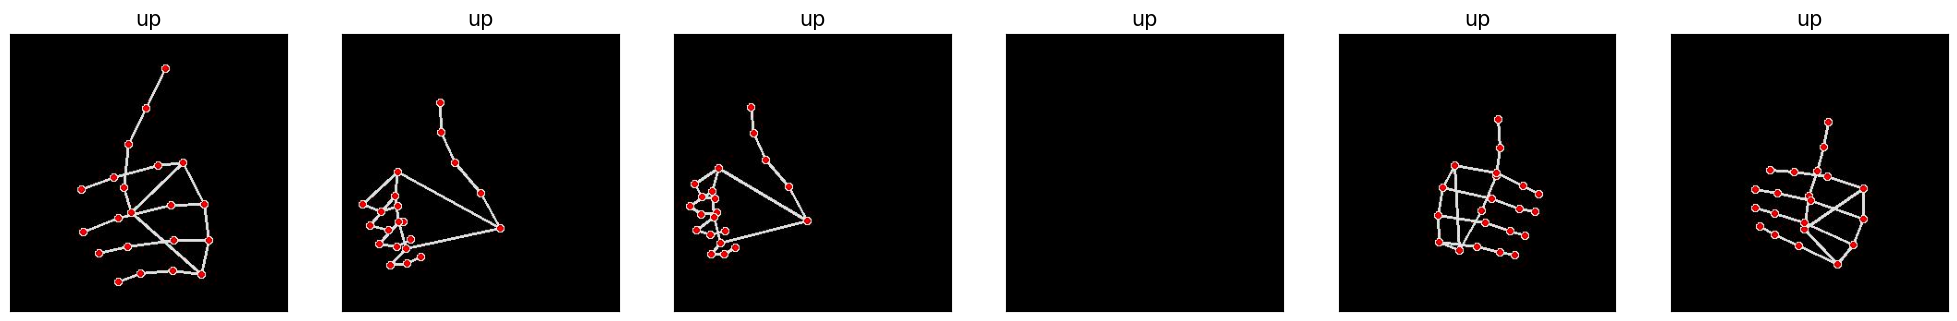

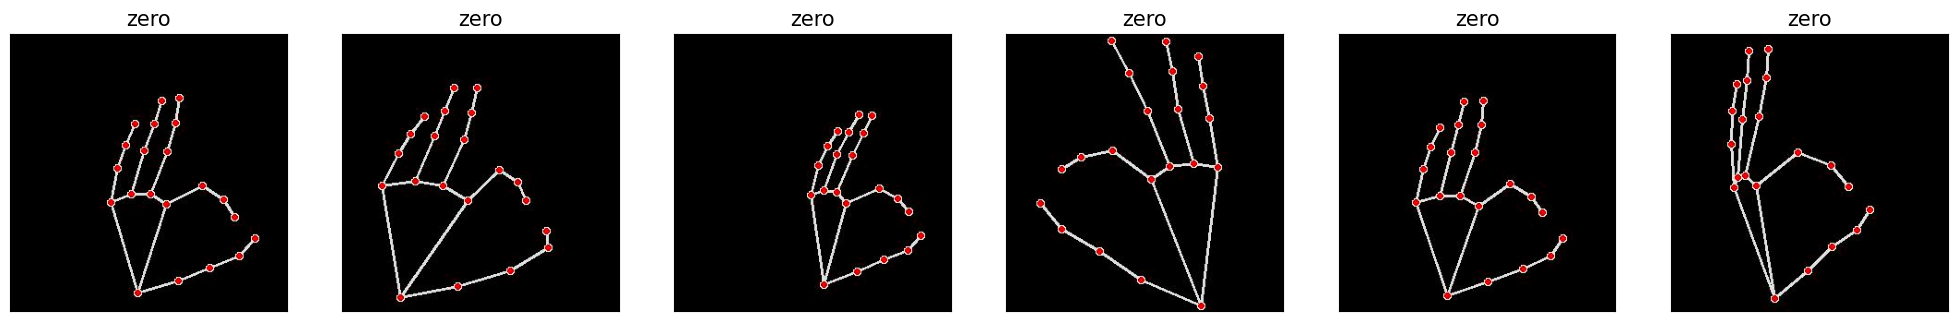

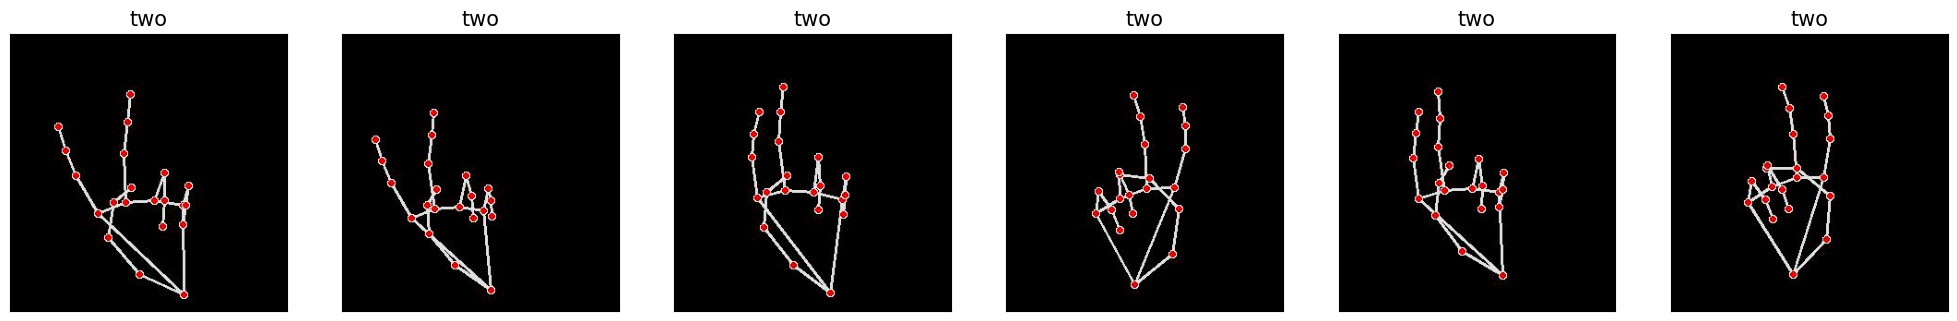

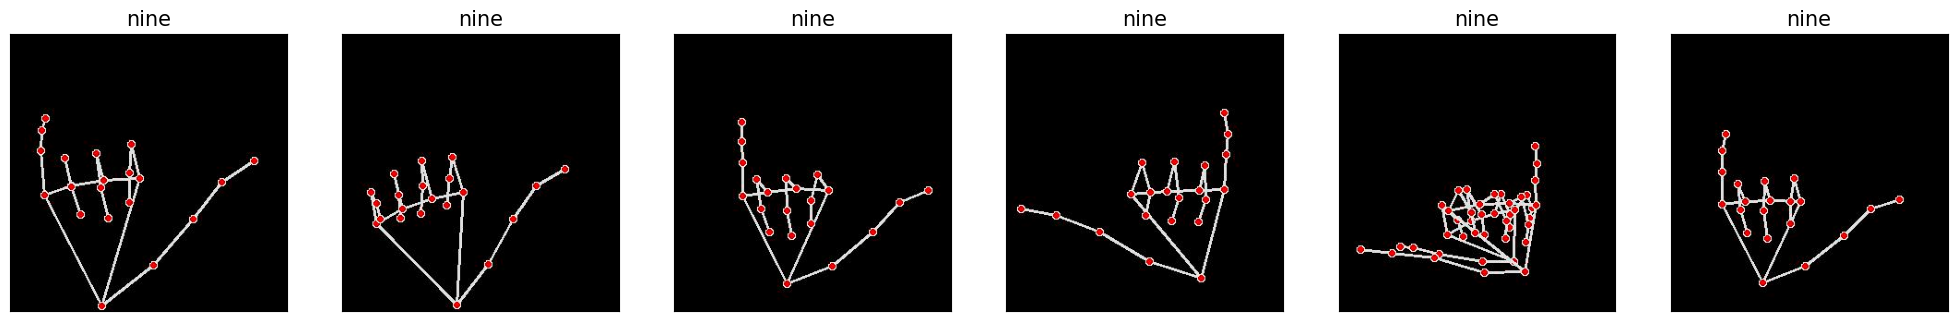

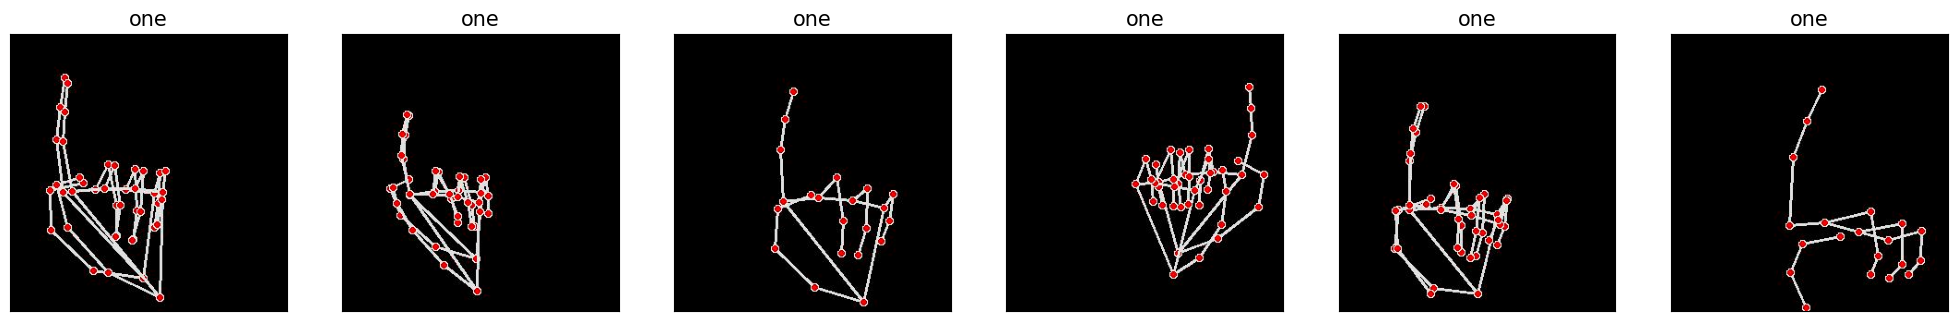

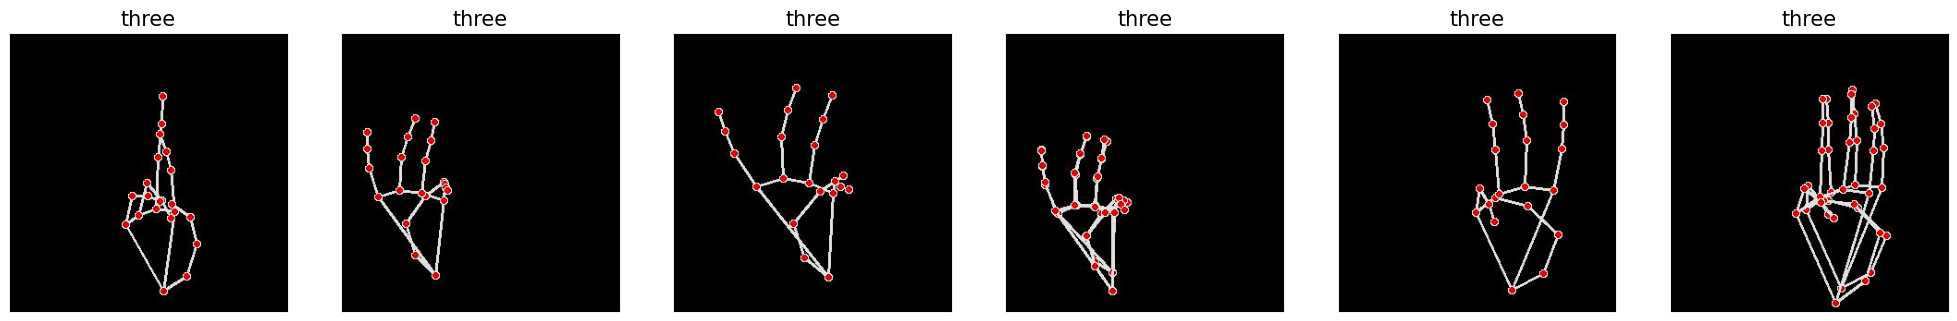

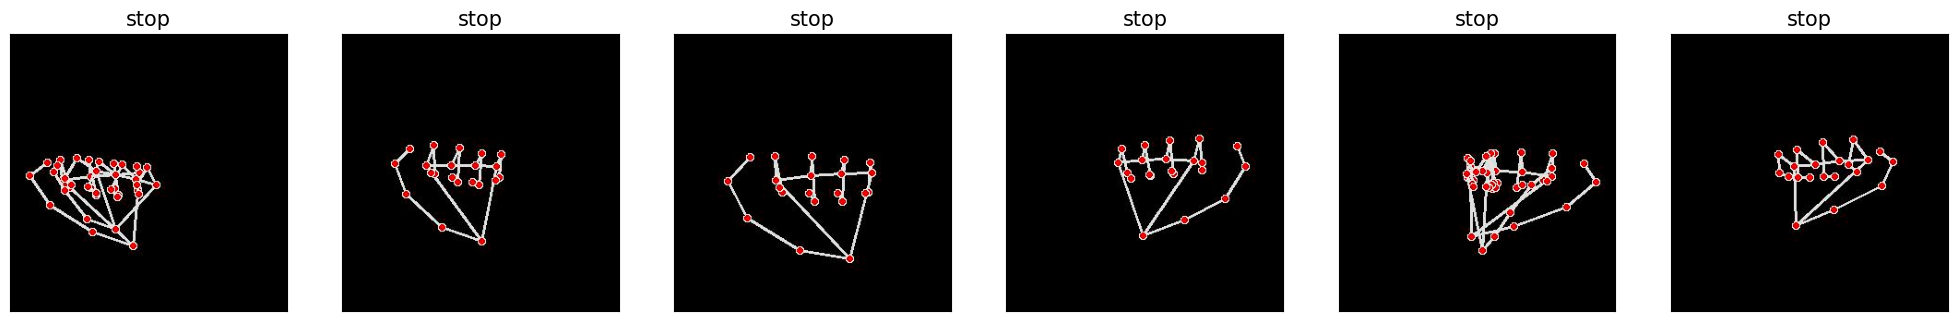

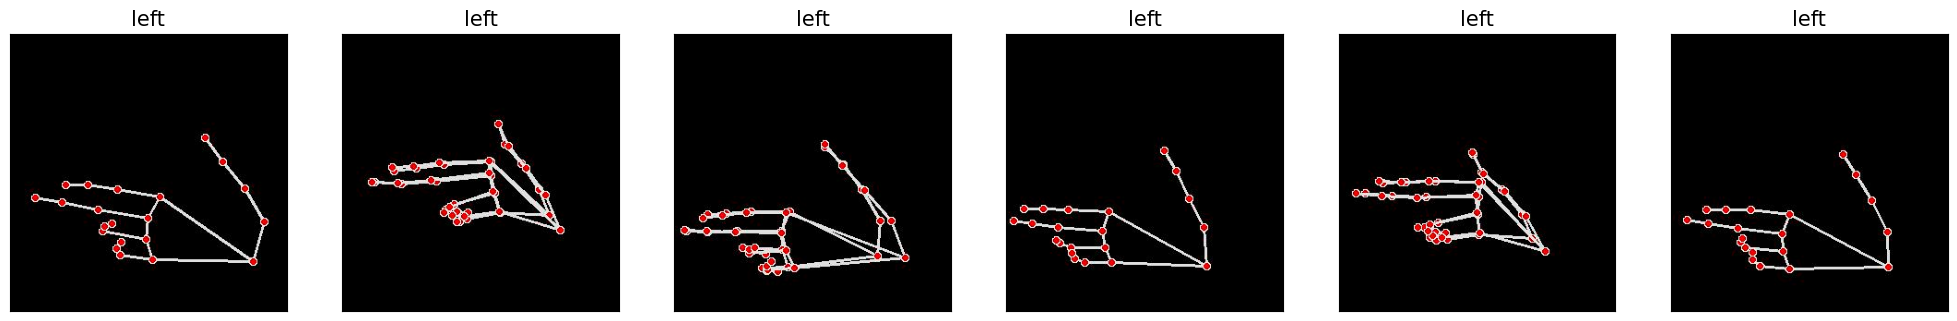

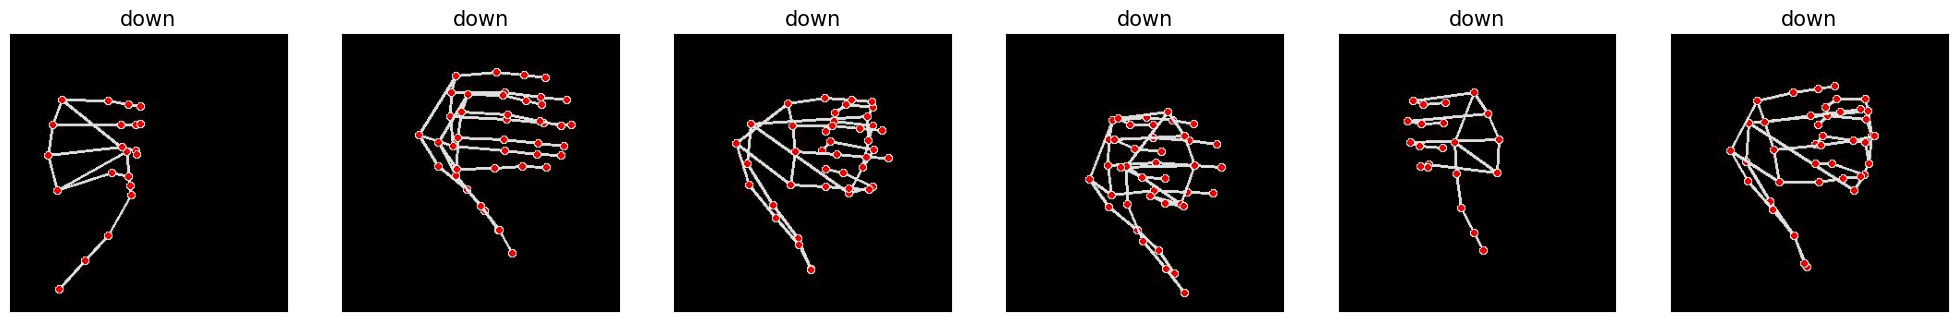

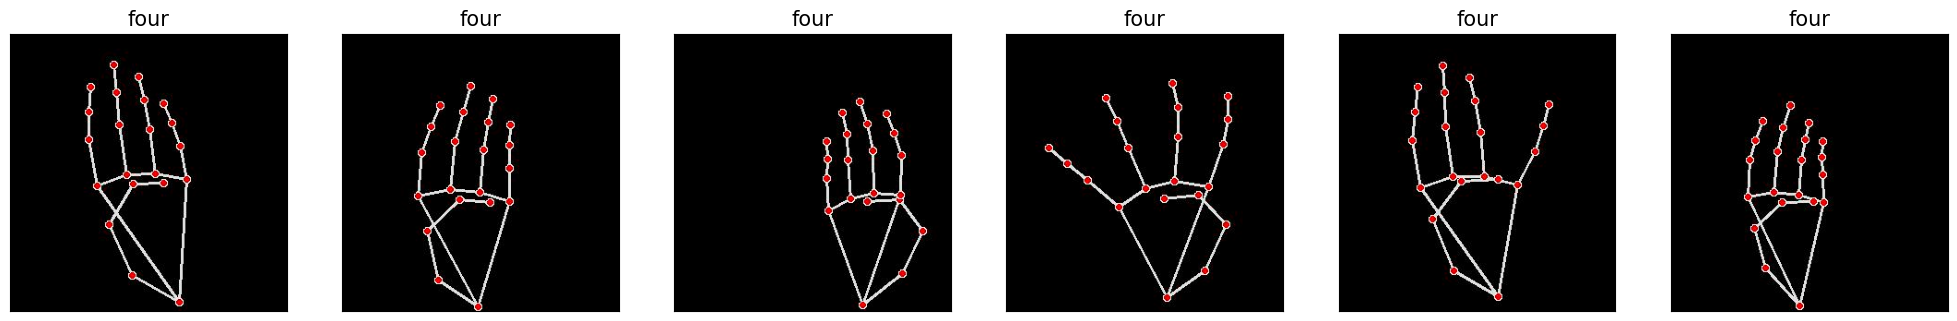

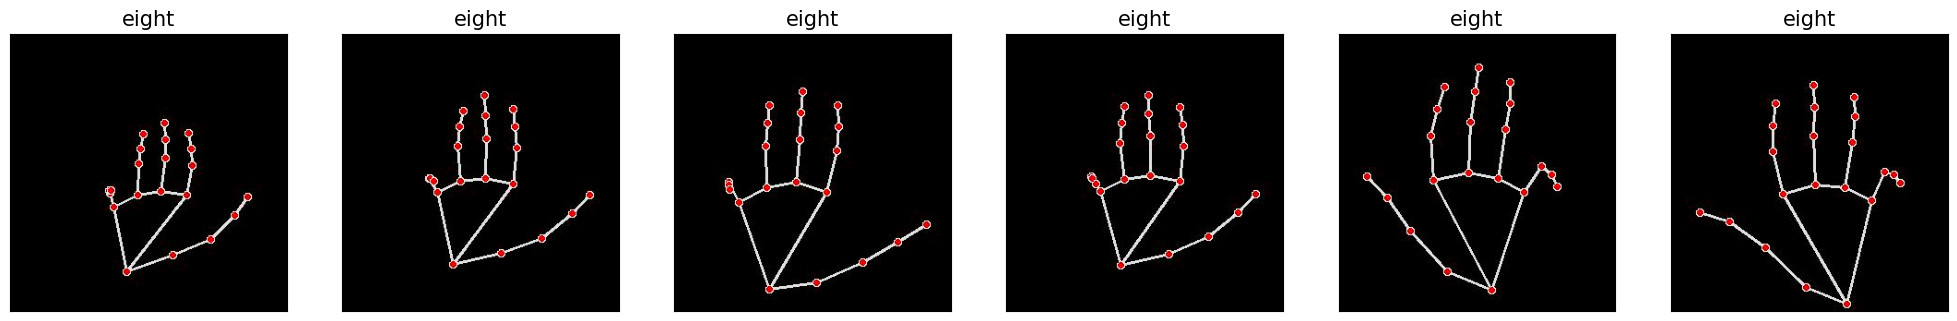

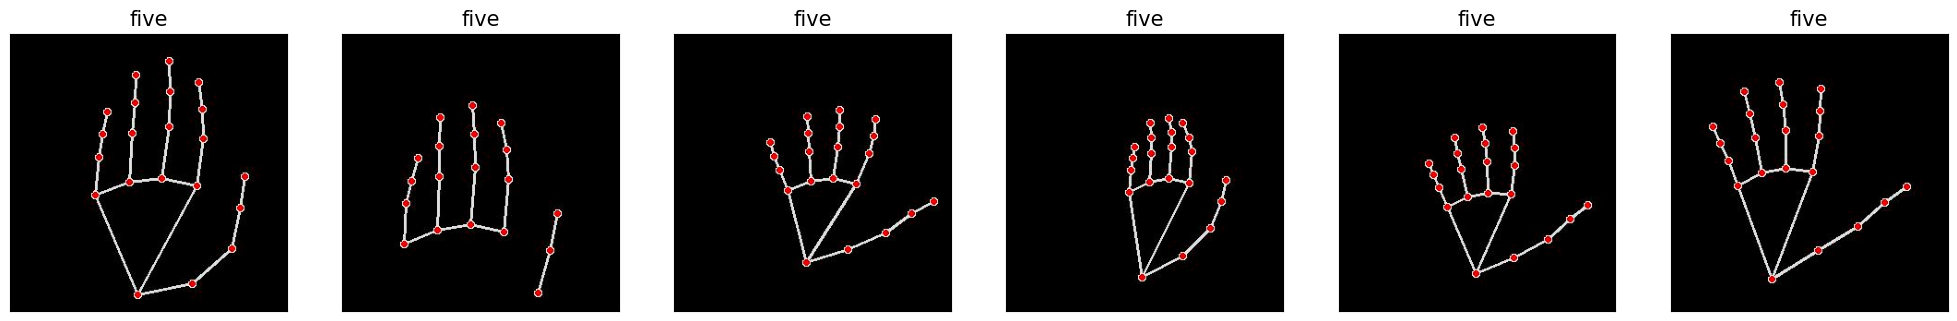

In [ ]:
for i in os.listdir(train_dir):
    imgs = os.listdir(os.path.join(train_dir, i))
    sample_imgs = random.sample(imgs, 6)

    fig, axes = plt.subplots(1,6, figsize=(25,4), subplot_kw=dict(xticks=[], yticks=[]))
    for num, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(os.path.join(train_dir, i, sample_imgs[num]))[:,:,::-1])
        ax.set_title(i, size=15)
plt.show()

### build the model

In [ ]:
train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                     horizontal_flip=True,
                                     zoom_range=0.1,
                                     shear_range=0.2,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     rotation_range=4,
                                     vertical_flip=False)

validation_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_generator.flow_from_directory(train_dir,
                                                     class_mode='categorical',
                                                     target_size=(48,48),
                                                     batch_size=32, shuffle=True)

validation_data_gen = validation_generator.flow_from_directory(val_dir,
                                                     class_mode='categorical',
                                                     target_size=(48,48),
                                                     batch_size=32, shuffle=False)

test_data_gen = test_generator.flow_from_directory(test_dir,
                                                     class_mode='categorical',
                                                     target_size=(48,48),
                                                     batch_size=32, shuffle=False)

Found 10518 images belonging to 15 classes.
Found 2253 images belonging to 15 classes.
Found 2256 images belonging to 15 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                        

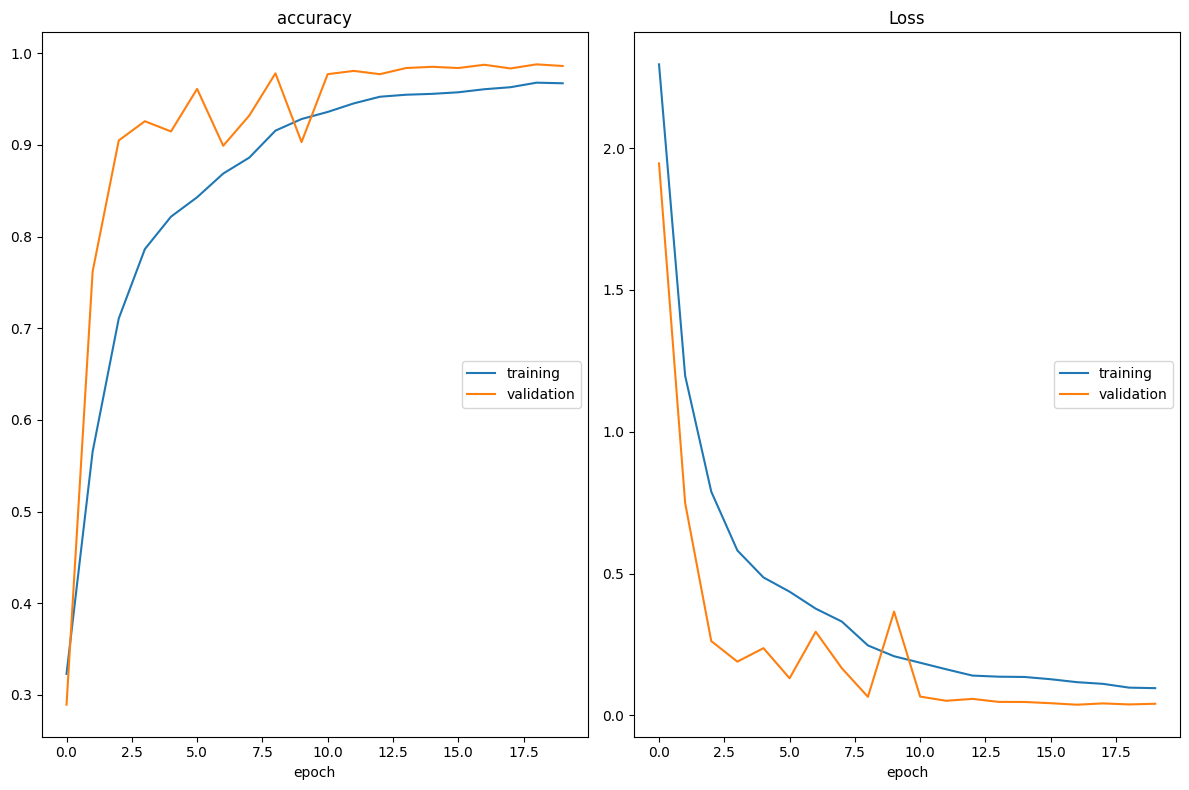

accuracy
	training         	 (min:    0.323, max:    0.968, cur:    0.967)
	validation       	 (min:    0.289, max:    0.988, cur:    0.986)
Loss
	training         	 (min:    0.096, max:    2.295, cur:    0.096)
	validation       	 (min:    0.038, max:    1.946, cur:    0.041)

Epoch 20: saving model to model_weights.weights.h5
328/328 [==============================] - 193s 589ms/step - loss: 0.0961 - accuracy: 0.9673 - val_loss: 0.0411 - val_accuracy: 0.9862 - lr: 1.2500e-04
Epoch 21/50
240/328 [====================>.........] - ETA: 46s - loss: 0.0964 - accuracy: 0.9673

In [ ]:
epochs = 50
steps_per_epoch = train_data_gen.n//32
validation_steps = validation_data_gen.n//32

checkpoint = ModelCheckpoint('model_weights.weights.h5', monitor='val_accuracy',save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x=train_data_gen,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_data_gen,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

### test the model

In [ ]:
model.evaluate(test_data_gen)

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9995 - loss: 0.0076


[0.007349673192948103, 0.9995555281639099]

In [ ]:
pred = model.predict(test_data_gen, test_data_gen.n//test_data_gen.batch_size)

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


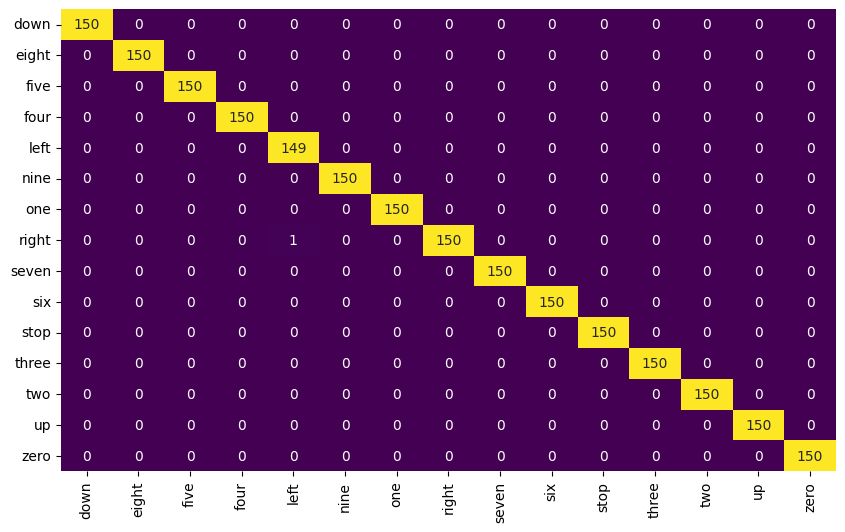

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(pred,axis=1), test_data_gen.classes), annot=True, xticklabels=test_data_gen.class_indices.keys(), yticklabels=test_data_gen.class_indices.keys(), cbar=False, cmap='viridis',fmt='')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

In [ ]:
print(classification_report(np.argmax(pred,axis=1), test_data_gen.classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       150
           4       0.99      1.00      1.00       149
           5       1.00      1.00      1.00       150
           6       1.00      1.00      1.00       150
           7       1.00      0.99      1.00       151
           8       1.00      1.00      1.00       150
           9       1.00      1.00      1.00       150
          10       1.00      1.00      1.00       150
          11       1.00      1.00      1.00       150
          12       1.00      1.00      1.00       150
          13       1.00      1.00      1.00       150
          14       1.00      1.00      1.00       150

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00   

In [ ]:
model_json = model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
model.save("full_model.h5")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,695 (56.23 MB)

 Trainable params: 4,913,231 (18.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,826,464 (37.48 MB)